In [1]:
import numpy as np
import pickle

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
def calculate_interpolatation_parameters(calibration_dict, roi_rgb_mean_normalized, roi_rgb_std_normalized):
    def model_func(x, a, b, c):
        return (a + b * x) / (c + x)
    
    interpolation_parameters = {}
    x_data = np.array(list(calibration_dict.values()))
    for color in ['r', 'g', 'b']:
        sigma = np.array([color_values[color] for color_values in roi_rgb_std_normalized.values()])
        y_median = np.array([color_values[color] for color_values in roi_rgb_mean_normalized.values()])

        initial_guess = [0.5, -0.001, 1]

        popt, _ = curve_fit(model_func, x_data, y_median, p0=initial_guess, sigma=sigma)
        fitted_a, fitted_b, fitted_c = popt

        print("Fitted parameters:")
        print("a =", fitted_a)
        print("b =", fitted_b)
        print("c =", fitted_c)
        interpolation_parameters[color] = {'a': fitted_a, 'b': fitted_b, 'c': fitted_c}
    return interpolation_parameters

def create_interpolation_plot(calibration_dict, roi_nodes_data_normalized, interpolation_parameters):
    def model_func(x, a, b, c):
        return (a + b * x) / (c + x)
    
    x_data = np.array(list(calibration_dict.values()))
    plt.figure(figsize=(10, 8))
    for i, color in enumerate(['r', 'g', 'b']):
        y_data_list = [color_values[:,:,i].flatten() for color_values in roi_nodes_data_normalized.values()]
        x_fit = np.linspace(min(x_data), max(x_data), 200)
        y_fit = model_func(x_fit, interpolation_parameters[color]['a'], interpolation_parameters[color]['b'], interpolation_parameters[color]['c'])

        # Create boxplot at each x_data point
        for x, y_list in zip(x_data, y_data_list):
            plt.boxplot(y_list, positions=[x], widths=max(x_data)/len(x_data)/4, vert=True, patch_artist=True, 
                        boxprops=dict(facecolor=color, alpha=0.5), 
                        capprops=dict(color=color), 
                        whiskerprops=dict(color=color), 
                        flierprops=dict(marker='.', color=color, alpha=0.07), 
                        medianprops=dict(color='black'))
        
        plt.plot(x_fit, y_fit, f'{color}-', label=f'Fitted curve ({color})')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.title("Interpolation with y = (a + b*x) / (c + x)")
    plt.show()


Fitted parameters:
a = 548.2355898752878
b = 0.03144142764554137
c = 816.1851553756356
Fitted parameters:
a = 1157.101060820834
b = 0.01553994790178386
c = 1719.0365239189507
Fitted parameters:
a = 1895.4509727948005
b = 0.13419158072704293
c = 3496.1808437114296


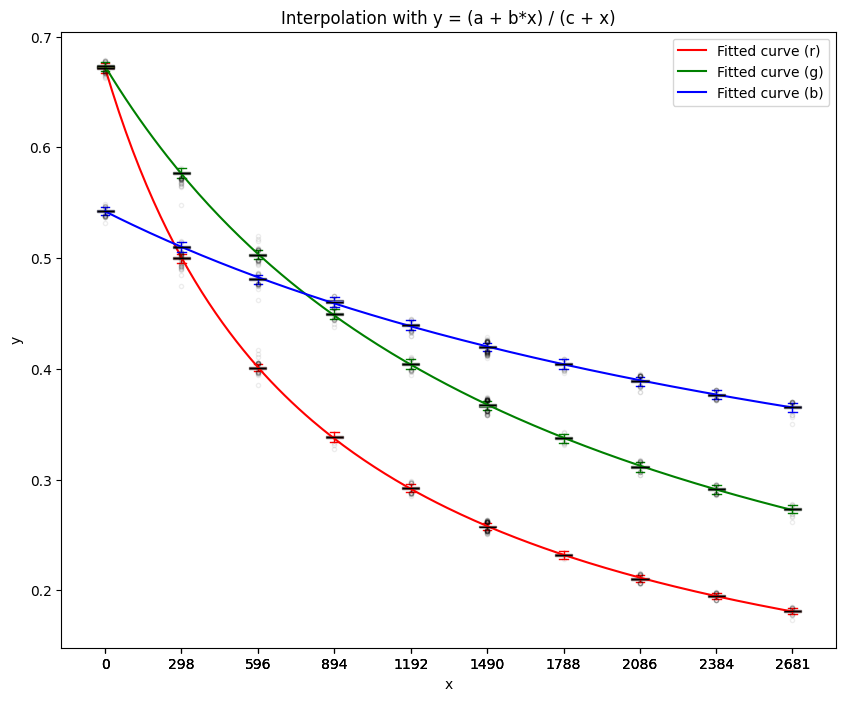

In [3]:
with open('data.pkl', 'rb') as f:
    roi_nodes_data = pickle.load(f)
with open(r"C:\Studia\Magisterka\dosymetry_slicer\Dawki_kalibracja.txt", 'r') as f:
    calibration_lines = [line.strip() for line in f.readlines() if line.strip() != '']
calibration_dict = {int(el[0].strip()): int(el[1].strip()) for el in [line.split('-') for line in calibration_lines]}

roi_nodes_data_normalized = {k: v / 2**16 for k, v in roi_nodes_data.items()}
roi_rgb_mean_normalized = {k: {c: v[:,:,i].mean() for i, c in enumerate(['r', 'g', 'b'])} for k, v in roi_nodes_data_normalized.items()}
roi_rgb_std_normalized = {k: {c: v[:,:,i].std() for i, c in enumerate(['r', 'g', 'b'])} for k, v in roi_nodes_data_normalized.items()}

interpolation_parameters = calculate_interpolatation_parameters(calibration_dict, roi_rgb_mean_normalized, roi_rgb_std_normalized)
create_interpolation_plot(calibration_dict, roi_nodes_data_normalized, interpolation_parameters)

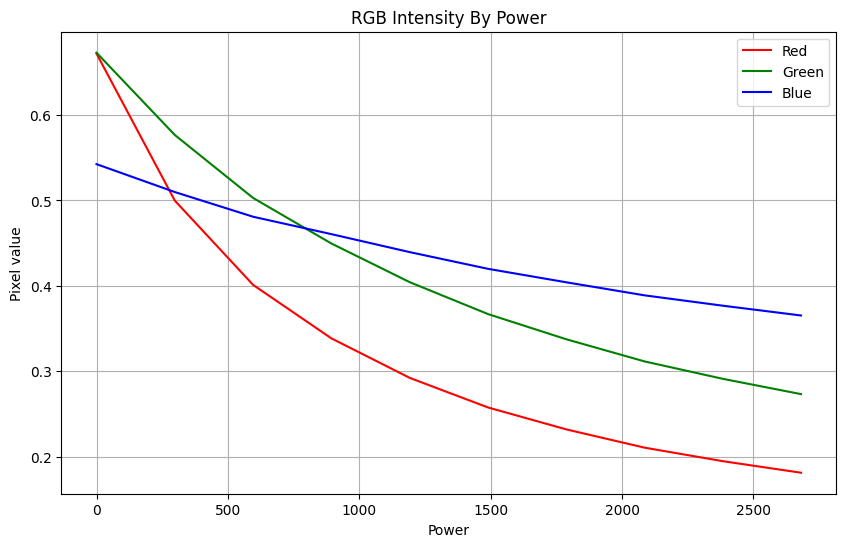

In [4]:
x_values = list(roi_rgb_mean_normalized.keys())

y_values_r = [roi_rgb_mean_normalized[t]['r'] for t in x_values]
y_values_g = [roi_rgb_mean_normalized[t]['g'] for t in x_values]
y_values_b = [roi_rgb_mean_normalized[t]['b'] for t in x_values]

plt.figure(figsize=(10, 6))
plt.plot(calibration_dict.values(), y_values_r, label='Red', color='red')
plt.plot(calibration_dict.values(), y_values_g, label='Green', color='green')
plt.plot(calibration_dict.values(), y_values_b, label='Blue', color='blue')

plt.xlabel('Power')
plt.ylabel('Pixel value')
plt.title('RGB Intensity By Power')
plt.legend()
plt.grid(True)

plt.show()
